# Module 7: Full Machine Learning Pipeline with MNIST (Interactive)
## From Data and EDA to Traditional ML and Neural Nets from Scratch

**Goal:** Walk through the complete ML pipeline on MNIST in a visual and highly interactive way.

This notebook is designed for intuition first:
- You will inspect data visually.
- You will compare preprocessing choices.
- You will train traditional ML and neural networks.
- You will control thresholds and watch TP/FP/TN/FN move live.

### Learning objectives
1. Understand each pipeline stage: data, EDA, labels, normalization, modeling, and evaluation.
2. See how traditional ML classifies and groups handwritten digits.
3. Build a binary neural net from scratch for **digit 1 vs not 1**.
4. Use threshold sliders to understand TP, FP, TN, FN and derived metrics.
5. Expand to multiclass (0-9) with a neural net from scratch and compare metric changes.

## Section 0: Pipeline map
A practical ML pipeline in this notebook:
1. **Data ingestion** (MNIST)
2. **EDA + labeling checks**
3. **Scaling/normalization**
4. **Traditional ML**
   - Supervised prediction (Logistic Regression)
   - Unsupervised grouping (KMeans)
5. **Neural network from scratch**
   - Binary (1 vs not 1)
   - Threshold-based clinical-style evaluation
   - Multiclass (all digits)
6. **Metric comparison and interpretation**

## Helper Functions
Run this cell once at the start. It configures local/Colab paths, dependencies, and plotting backends.

In [15]:
import os
import re
import sys
import urllib.request
import subprocess
from pathlib import Path
from importlib import import_module
from importlib.metadata import PackageNotFoundError, version


def setup_repo_for_colab(
    repo_url='https://github.com/aaekay/Medical-AI-101.git',
    repo_dir='/content/Medical-AI-101',
    notebook_dir='chapters',
):
    if 'google.colab' not in sys.modules:
        print(f'Local runtime detected. Working directory: {Path.cwd()}')
        return

    repo_path = Path(repo_dir)
    if not repo_path.exists():
        print('Cloning Medical-AI-101 into /content ...')
        subprocess.check_call(['git', 'clone', repo_url, str(repo_path)])

    target = repo_path / notebook_dir
    os.chdir(target)
    print(f'Colab ready. Working directory: {Path.cwd()}')


def _parse_version(version_str):
    parts = [int(p) for p in re.findall(r'\d+', version_str)]
    return tuple((parts + [0, 0, 0])[:3])


def ensure_dependency(package_name, import_name=None, min_version=None):
    import_name = import_name or package_name

    needs_install = False
    install_reason = ''

    try:
        import_module(import_name)
    except ImportError:
        needs_install = True
        install_reason = 'not installed'

    installed_version = None
    if not needs_install:
        try:
            installed_version = version(package_name)
        except PackageNotFoundError:
            needs_install = True
            install_reason = 'distribution metadata missing'

    if not needs_install and min_version and installed_version:
        if _parse_version(installed_version) < _parse_version(min_version):
            needs_install = True
            install_reason = f'version {installed_version} < required {min_version}'

    requirement = f'{package_name}>={min_version}' if min_version else package_name

    if needs_install:
        print(f'Installing {requirement} ({install_reason}) ...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', requirement])
        import_module(import_name)
        installed_version = version(package_name)

    print(f'{package_name} ready: {installed_version}')


def configure_plotly_renderer():
    import plotly.io as pio

    renderers_obj = pio.renderers
    available = set()

    names = getattr(renderers_obj, 'names', None)
    if names:
        available = set(names)
    elif hasattr(renderers_obj, 'keys'):
        try:
            available = set(renderers_obj.keys())
        except Exception:
            available = set()

    if not available:
        try:
            available = set(list(renderers_obj))
        except Exception:
            available = set()

    candidates = []
    if 'google.colab' in sys.modules:
        candidates.append('colab')
    candidates.extend(['plotly_mimetype', 'notebook_connected', 'notebook', 'browser'])

    renderer = next((name for name in candidates if name in available), None)
    if renderer is None:
        renderer = renderers_obj.default or 'browser'

    try:
        renderers_obj.default = renderer
        print(f'Plotly renderer set to: {renderer}')
    except Exception:
        fallback = 'browser' if 'browser' in available else renderers_obj.default
        renderers_obj.default = fallback
        print(f'Plotly renderer set to fallback: {fallback}')


setup_repo_for_colab()
ensure_dependency('numpy')
ensure_dependency('pandas')
ensure_dependency('matplotlib')
ensure_dependency('ipywidgets')
ensure_dependency('plotly')
ensure_dependency('nbformat', min_version='4.2.0')
ensure_dependency('ipython', import_name='IPython')
ensure_dependency('scikit-learn', import_name='sklearn')
configure_plotly_renderer()

Local runtime detected. Working directory: /Users/aaekay/Documents/projects/Medical-AI-101/chapters
numpy ready: 2.3.0
pandas ready: 2.3.0
matplotlib ready: 3.10.3
ipywidgets ready: 8.1.7
plotly ready: 6.5.2
nbformat ready: 5.10.4
ipython ready: 9.3.0
scikit-learn ready: 1.7.0
Plotly renderer set to: plotly_mimetype


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from IPython.display import display, Markdown

try:
    import ipywidgets as widgets
except ImportError as exc:
    raise ImportError('ipywidgets is required. Install with `pip install ipywidgets`.') from exc

from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')


def stratified_subset(X, y, n_samples, random_state=42):
    if n_samples is None or n_samples >= len(X):
        return X, y
    X_sub, _, y_sub, _ = train_test_split(
        X,
        y,
        train_size=n_samples,
        stratify=y,
        random_state=random_state,
    )
    return X_sub, y_sub


def try_load_mnist_npz(cache_path='data/mnist.npz'):
    cache = Path(cache_path)
    cache.parent.mkdir(parents=True, exist_ok=True)

    if not cache.exists():
        url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
        urllib.request.urlretrieve(url, cache)

    with np.load(cache) as data:
        X_train = data['x_train'].reshape(-1, 28 * 28).astype(np.float32)
        y_train = data['y_train'].astype(int)
        X_test = data['x_test'].reshape(-1, 28 * 28).astype(np.float32)
        y_test = data['y_test'].astype(int)

    return X_train, y_train, X_test, y_test


def load_mnist_data():
    errors = []

    try:
        X_train, y_train, X_test, y_test = try_load_mnist_npz()
        return X_train, y_train, X_test, y_test, 'MNIST (mnist.npz)'
    except Exception as exc:
        errors.append(f'mnist.npz failed: {exc}')

    try:
        mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
        X = mnist.data.astype(np.float32)
        y = mnist.target.astype(int)
        X_train, X_test = X[:60000], X[60000:]
        y_train, y_test = y[:60000], y[60000:]
        return X_train, y_train, X_test, y_test, 'MNIST (OpenML)'
    except Exception as exc:
        errors.append(f'OpenML MNIST failed: {exc}')

    # Fallback keeps notebook runnable when network is blocked.
    digits = load_digits()
    X = digits.data.astype(np.float32)
    y = digits.target.astype(int)
    X = (X / 16.0) * 255.0
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )
    print('Warning: Using sklearn digits fallback because MNIST download failed.')
    for e in errors:
        print(' -', e)
    return X_train, y_train, X_test, y_test, 'sklearn digits fallback (8x8)'


X_train_raw, y_train, X_test_raw, y_test, dataset_source = load_mnist_data()

# Keep runtime manageable while preserving class balance.
X_train_raw, y_train = stratified_subset(X_train_raw, y_train, n_samples=12000)
X_test_raw, y_test = stratified_subset(X_test_raw, y_test, n_samples=3000)

IMAGE_SIDE = int(np.sqrt(X_train_raw.shape[1]))

print(f'Dataset source: {dataset_source}')
print(f'Train shape: {X_train_raw.shape}, Test shape: {X_test_raw.shape}, Image side: {IMAGE_SIDE}x{IMAGE_SIDE}')

Dataset source: MNIST (mnist.npz)
Train shape: (12000, 784), Test shape: (3000, 784), Image side: 28x28


## Section 1: Data, EDA, and labels
MNIST is already labeled (each image has a digit label 0-9), but we still inspect:
- Class balance
- Pixel value ranges
- Sample quality
- Label encoding for models

In [17]:
def show_digit(index=0, split='train', cmap='gray'):
    if split == 'train':
        X, y = X_train_raw, y_train
    else:
        X, y = X_test_raw, y_test

    index = int(np.clip(index, 0, len(X) - 1))
    img = X[index].reshape(IMAGE_SIDE, IMAGE_SIDE)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3.6))

    axes[0].imshow(img, cmap=cmap)
    axes[0].set_title(f'{split} index={index}, label={int(y[index])}')
    axes[0].axis('off')

    axes[1].hist(X[index], bins=20, color='#2563eb', alpha=0.8)
    axes[1].set_title('Pixel intensity histogram')
    axes[1].set_xlabel('Pixel value')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


widgets.interact(
    show_digit,
    index=widgets.IntSlider(min=0, max=len(X_train_raw) - 1, step=1, value=0, description='Index'),
    split=widgets.Dropdown(options=['train', 'test'], value='train', description='Split'),
    cmap=widgets.Dropdown(options=['gray', 'viridis', 'magma'], value='gray', description='Colormap'),
)

interactive(children=(IntSlider(value=0, description='Index', max=11999), Dropdown(description='Split', option…

<function __main__.show_digit(index=0, split='train', cmap='gray')>

In [18]:
train_counts = pd.Series(y_train).value_counts().sort_index()
fig = px.bar(
    x=train_counts.index.astype(str),
    y=train_counts.values,
    labels={'x': 'Digit label', 'y': 'Count'},
    title='Label distribution in training data',
    color=train_counts.index.astype(str),
)
fig.update_layout(showlegend=False, height=360)
fig.show()


def show_examples_for_label(label=1, n_examples=12, seed=42):
    idx = np.where(y_train == label)[0]
    rng = np.random.default_rng(seed)
    pick = rng.choice(idx, size=min(n_examples, len(idx)), replace=False)

    rows, cols = 3, 4
    fig, axes = plt.subplots(rows, cols, figsize=(7, 5.2))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < len(pick):
            ax.imshow(X_train_raw[pick[i]].reshape(IMAGE_SIDE, IMAGE_SIDE), cmap='gray')
            ax.set_title(f'idx {pick[i]}', fontsize=8)
        ax.axis('off')

    plt.suptitle(f'Random training examples for label {label}', y=1.02)
    plt.tight_layout()
    plt.show()


widgets.interact(
    show_examples_for_label,
    label=widgets.IntSlider(min=0, max=9, step=1, value=1, description='Digit'),
    n_examples=widgets.IntSlider(min=4, max=16, step=4, value=12, description='Examples'),
    seed=widgets.IntSlider(min=1, max=999, step=1, value=42, description='Seed'),
)

label_demo = pd.DataFrame({'y_label': y_train[:8]})
one_hot_demo = pd.DataFrame(np.eye(10, dtype=int)[y_train[:8]], columns=[f'class_{i}' for i in range(10)])
display(Markdown('**Labeling demo: raw labels and one-hot encoding (first 8 rows)**'))
display(pd.concat([label_demo, one_hot_demo], axis=1))

interactive(children=(IntSlider(value=1, description='Digit', max=9), IntSlider(value=12, description='Example…

**Labeling demo: raw labels and one-hot encoding (first 8 rows)**

,y_label,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,8,0,0,0,0,0,0,0,0,1,0
1,4,0,0,0,0,1,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,1,0
3,2,0,0,1,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,0
6,3,0,0,0,1,0,0,0,0,0,0
7,2,0,0,1,0,0,0,0,0,0,0


## Section 2: Scaling and normalization
Raw pixels can be transformed in multiple ways. We compare:
- Raw: values in 0-255 range (or fallback range)
- Min-max: scaled to 0-1
- Z-score: centered and standardized using train statistics

In [19]:
X_train_minmax = X_train_raw / np.maximum(X_train_raw.max(), 1.0)
X_test_minmax = X_test_raw / np.maximum(X_train_raw.max(), 1.0)

train_mean = X_train_raw.mean(axis=0, keepdims=True)
train_std = X_train_raw.std(axis=0, keepdims=True) + 1e-8
X_train_z = (X_train_raw - train_mean) / train_std
X_test_z = (X_test_raw - train_mean) / train_std


def get_representation(split='train', mode='Raw'):
    if split == 'train':
        if mode == 'Raw':
            return X_train_raw
        if mode == 'Min-Max (0-1)':
            return X_train_minmax
        return X_train_z

    if mode == 'Raw':
        return X_test_raw
    if mode == 'Min-Max (0-1)':
        return X_test_minmax
    return X_test_z


def compare_normalization(index=0, split='train', left_mode='Raw', right_mode='Min-Max (0-1)'):
    left = get_representation(split, left_mode)
    right = get_representation(split, right_mode)
    y = y_train if split == 'train' else y_test

    index = int(np.clip(index, 0, len(left) - 1))
    left_img = left[index].reshape(IMAGE_SIDE, IMAGE_SIDE)
    right_img = right[index].reshape(IMAGE_SIDE, IMAGE_SIDE)

    fig, axes = plt.subplots(2, 2, figsize=(8.5, 6.2))

    axes[0, 0].imshow(left_img, cmap='gray')
    axes[0, 0].set_title(f'{left_mode} | label={int(y[index])}')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(right_img, cmap='gray')
    axes[0, 1].set_title(f'{right_mode} | label={int(y[index])}')
    axes[0, 1].axis('off')

    axes[1, 0].hist(left[index], bins=20, color='#2563eb', alpha=0.85)
    axes[1, 0].set_title(f'{left_mode} histogram')

    axes[1, 1].hist(right[index], bins=20, color='#f97316', alpha=0.85)
    axes[1, 1].set_title(f'{right_mode} histogram')

    plt.tight_layout()
    plt.show()

    stats = pd.DataFrame([
        {'View': left_mode, 'Min': float(left[index].min()), 'Max': float(left[index].max()), 'Mean': float(left[index].mean()), 'Std': float(left[index].std())},
        {'View': right_mode, 'Min': float(right[index].min()), 'Max': float(right[index].max()), 'Mean': float(right[index].mean()), 'Std': float(right[index].std())},
    ])
    display(stats)


widgets.interact(
    compare_normalization,
    index=widgets.IntSlider(min=0, max=len(X_train_raw) - 1, step=1, value=0, description='Index'),
    split=widgets.Dropdown(options=['train', 'test'], value='train', description='Split'),
    left_mode=widgets.Dropdown(options=['Raw', 'Min-Max (0-1)', 'Z-score'], value='Raw', description='Left'),
    right_mode=widgets.Dropdown(options=['Raw', 'Min-Max (0-1)', 'Z-score'], value='Min-Max (0-1)', description='Right'),
)

interactive(children=(IntSlider(value=0, description='Index', max=11999), Dropdown(description='Split', option…

<function __main__.compare_normalization(index=0, split='train', left_mode='Raw', right_mode='Min-Max (0-1)')>

## Section 3: Traditional ML
We now use min-max normalized data for two tasks:
1. **Prediction:** Logistic Regression (supervised)
2. **Grouping:** KMeans clustering (unsupervised)

Training traditional models...


/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning:

overflow encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning:

invalid value encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:44: RuntimeWarning:

divide by zero encountered in dot

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:44: RuntimeWarning:

overflow encountered in dot

/Users

,Model,Task,Accuracy
0,Logistic Regression,Supervised prediction,0.906333
1,KMeans + majority mapping,Unsupervised grouping,0.588000


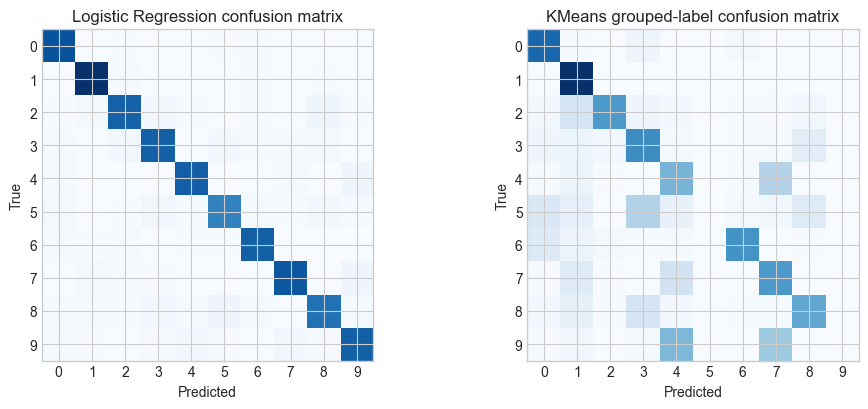

In [20]:
X_train_trad = X_train_minmax
X_test_trad = X_test_minmax

print('Training traditional models...')

# Supervised baseline: Logistic Regression
logreg_model = LogisticRegression(
    max_iter=220,
    multi_class='auto',
    solver='lbfgs',
    n_jobs=None,
)
logreg_model.fit(X_train_trad, y_train)
logreg_pred = logreg_model.predict(X_test_trad)
logreg_acc = accuracy_score(y_test, logreg_pred)

# Grouping baseline: KMeans
kmeans_model = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_model.fit(X_train_trad)
train_clusters = kmeans_model.predict(X_train_trad)
test_clusters = kmeans_model.predict(X_test_trad)

# Map clusters to labels by majority vote.
cluster_to_label = {}
for c in range(10):
    mask = train_clusters == c
    if mask.sum() == 0:
        cluster_to_label[c] = 0
    else:
        cluster_to_label[c] = int(pd.Series(y_train[mask]).mode()[0])

kmeans_pred_label = np.array([cluster_to_label[c] for c in test_clusters])
kmeans_acc = accuracy_score(y_test, kmeans_pred_label)

summary_df = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Task': 'Supervised prediction', 'Accuracy': logreg_acc},
    {'Model': 'KMeans + majority mapping', 'Task': 'Unsupervised grouping', 'Accuracy': kmeans_acc},
])
display(summary_df)

logreg_cm = confusion_matrix(y_test, logreg_pred)
kmeans_cm = confusion_matrix(y_test, kmeans_pred_label)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
for ax, cm, title in [
    (axes[0], logreg_cm, 'Logistic Regression confusion matrix'),
    (axes[1], kmeans_cm, 'KMeans grouped-label confusion matrix'),
]:
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))

plt.tight_layout()
plt.show()

In [21]:
pca_2d = PCA(n_components=2, random_state=42)
X_test_2d = pca_2d.fit_transform(X_test_trad)

viz_df = pd.DataFrame({
    'pc1': X_test_2d[:, 0],
    'pc2': X_test_2d[:, 1],
    'true_label': y_test.astype(str),
    'cluster_id': test_clusters.astype(str),
})


def show_pca_view(color_by='true_label', sample_size=1200, seed=42):
    n = min(sample_size, len(viz_df))
    plot_df = viz_df.sample(n=n, random_state=seed)
    fig = px.scatter(
        plot_df,
        x='pc1',
        y='pc2',
        color=color_by,
        opacity=0.65,
        title=f'2D PCA view colored by {color_by}',
        height=460,
    )
    fig.show()


widgets.interact(
    show_pca_view,
    color_by=widgets.Dropdown(options=['true_label', 'cluster_id'], value='true_label', description='Color by'),
    sample_size=widgets.IntSlider(min=300, max=min(3000, len(viz_df)), step=100, value=min(1200, len(viz_df)), description='Points'),
    seed=widgets.IntSlider(min=1, max=999, step=1, value=42, description='Seed'),
)

cluster_centers = kmeans_model.cluster_centers_

def show_cluster_prototype(cluster_id=0):
    center_img = cluster_centers[cluster_id].reshape(IMAGE_SIDE, IMAGE_SIDE)
    mapped_label = cluster_to_label[cluster_id]
    plt.figure(figsize=(2.8, 2.8))
    plt.imshow(center_img, cmap='gray')
    plt.title(f'Cluster {cluster_id} prototype\nmajority label={mapped_label}')
    plt.axis('off')
    plt.show()


widgets.interact(
    show_cluster_prototype,
    cluster_id=widgets.IntSlider(min=0, max=9, step=1, value=0, description='Cluster'),
)

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:355: RuntimeWarning:

divide by zero encountered in matmul

/Users/aaekay/miniconda3/lib/python3.13/s

interactive(children=(Dropdown(description='Color by', options=('true_label', 'cluster_id'), value='true_label…

interactive(children=(IntSlider(value=0, description='Cluster', max=9), Output()), _dom_classes=('widget-inter…

<function __main__.show_cluster_prototype(cluster_id=0)>

## Section 4: Neural Network from scratch (binary) - "1" vs "not 1"
Now we build a neural network in pure NumPy.

Task:
- Positive class: digit **1**
- Negative class: digits **0,2,3,4,5,6,7,8,9**

In [22]:
def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    return (x > 0).astype(np.float32)


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def bce_loss(y_true, y_prob, eps=1e-9):
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


def init_binary_params(input_dim, hidden_dim=48, seed=42):
    rng = np.random.default_rng(seed)
    W1 = rng.normal(0, np.sqrt(2 / input_dim), size=(input_dim, hidden_dim)).astype(np.float32)
    b1 = np.zeros((1, hidden_dim), dtype=np.float32)
    W2 = rng.normal(0, np.sqrt(2 / hidden_dim), size=(hidden_dim, 1)).astype(np.float32)
    b2 = np.zeros((1, 1), dtype=np.float32)
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


def binary_forward(X, params):
    Z1 = X @ params['W1'] + params['b1']
    A1 = relu(Z1)
    Z2 = A1 @ params['W2'] + params['b2']
    A2 = sigmoid(Z2)
    cache = {'X': X, 'Z1': Z1, 'A1': A1, 'A2': A2}
    return A2, cache


def binary_backward(y_true, params, cache):
    X, Z1, A1, A2 = cache['X'], cache['Z1'], cache['A1'], cache['A2']
    m = X.shape[0]

    dZ2 = (A2 - y_true)
    dW2 = (A1.T @ dZ2) / m
    db2 = np.mean(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ params['W2'].T
    dZ1 = dA1 * relu_grad(Z1)
    dW1 = (X.T @ dZ1) / m
    db1 = np.mean(dZ1, axis=0, keepdims=True)

    return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}


def train_binary_nn(X_train, y_train, X_val, y_val, hidden_dim=48, epochs=24, lr=0.08, batch_size=128, seed=42):
    params = init_binary_params(X_train.shape[1], hidden_dim=hidden_dim, seed=seed)
    rng = np.random.default_rng(seed)
    history = {'train_loss': [], 'val_loss': []}

    y_train_2d = y_train.reshape(-1, 1).astype(np.float32)
    y_val_2d = y_val.reshape(-1, 1).astype(np.float32)

    for epoch in range(epochs):
        idx = rng.permutation(len(X_train))
        X_shuf = X_train[idx]
        y_shuf = y_train_2d[idx]

        for start in range(0, len(X_shuf), batch_size):
            end = start + batch_size
            xb = X_shuf[start:end]
            yb = y_shuf[start:end]

            y_prob, cache = binary_forward(xb, params)
            grads = binary_backward(yb, params, cache)

            params['W1'] -= lr * grads['dW1']
            params['b1'] -= lr * grads['db1']
            params['W2'] -= lr * grads['dW2']
            params['b2'] -= lr * grads['db2']

        train_prob, _ = binary_forward(X_train, params)
        val_prob, _ = binary_forward(X_val, params)
        history['train_loss'].append(float(bce_loss(y_train_2d, train_prob)))
        history['val_loss'].append(float(bce_loss(y_val_2d, val_prob)))

        if (epoch + 1) % 4 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1:02d}/{epochs} | train_loss={history["train_loss"][-1]:.4f} | val_loss={history["val_loss"][-1]:.4f}')

    return params, history

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:28: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:28: RuntimeWarning:

overflow encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:28: RuntimeWarning:

invalid value encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:30: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:30: RuntimeWarning:

overflow encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:30: RuntimeWarning:

invalid value encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/3406870679.py:41: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T

Training binary neural network from scratch (1 vs not 1)...
Epoch 01/24 | train_loss=0.0627 | val_loss=0.0603
Epoch 04/24 | train_loss=0.0397 | val_loss=0.0397
Epoch 08/24 | train_loss=0.0334 | val_loss=0.0344
Epoch 12/24 | train_loss=0.0297 | val_loss=0.0306
Epoch 16/24 | train_loss=0.0269 | val_loss=0.0280
Epoch 20/24 | train_loss=0.0242 | val_loss=0.0271
Epoch 24/24 | train_loss=0.0221 | val_loss=0.0263


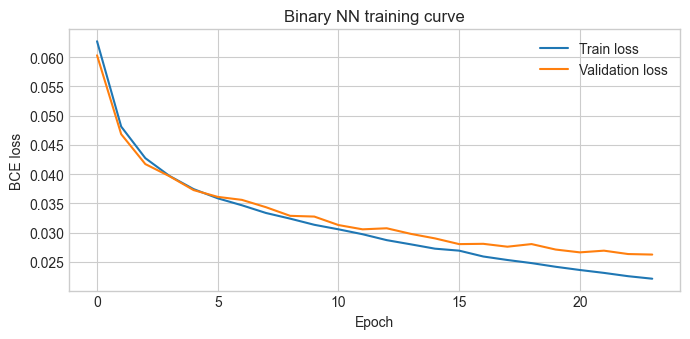

In [23]:
X_train_nn = X_train_minmax.astype(np.float32)
X_test_nn = X_test_minmax.astype(np.float32)

y_train_bin = (y_train == 1).astype(np.float32)
y_test_bin = (y_test == 1).astype(np.float32)

# Use a compact train/validation split for fast notebook execution.
X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(
    X_train_nn,
    y_train_bin,
    test_size=0.2,
    stratify=y_train_bin,
    random_state=42,
)

print('Training binary neural network from scratch (1 vs not 1)...')
bin_params, bin_history = train_binary_nn(
    X_bin_train,
    y_bin_train,
    X_bin_val,
    y_bin_val,
    hidden_dim=48,
    epochs=24,
    lr=0.08,
    batch_size=128,
)

plt.figure(figsize=(7, 3.5))
plt.plot(bin_history['train_loss'], label='Train loss')
plt.plot(bin_history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('BCE loss')
plt.title('Binary NN training curve')
plt.legend()
plt.tight_layout()
plt.show()

bin_test_prob, _ = binary_forward(X_test_nn, bin_params)
bin_test_prob = bin_test_prob.ravel()

In [24]:
def binary_metrics_from_threshold(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    y_true = y_true.astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    return {
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'pred': y_pred,
    }


def binary_threshold_dashboard(threshold=0.5, sample_index=0):
    m = binary_metrics_from_threshold(y_test_bin, bin_test_prob, threshold)

    cm = np.array([[m['tn'], m['fp']], [m['fn'], m['tp']]])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im = axes[0].imshow(cm, cmap='Blues')
    axes[0].set_xticks([0, 1])
    axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(['Pred 0', 'Pred 1'])
    axes[0].set_yticklabels(['True 0', 'True 1'])
    axes[0].set_title(f'Confusion matrix @ threshold={threshold:.2f}')
    for i in range(2):
        for j in range(2):
            axes[0].text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

    sample_index = int(np.clip(sample_index, 0, len(X_test_raw) - 1))
    img = X_test_raw[sample_index].reshape(IMAGE_SIDE, IMAGE_SIDE)
    prob = float(bin_test_prob[sample_index])
    pred = int(prob >= threshold)
    true = int(y_test_bin[sample_index])

    axes[1].imshow(img, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(
        f'Sample idx={sample_index} | true={true} | prob(1)={prob:.3f} | pred={pred}'
    )

    plt.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame([
        {'Metric': 'Accuracy', 'Value': m['accuracy']},
        {'Metric': 'Precision (PPV)', 'Value': m['precision']},
        {'Metric': 'Recall (Sensitivity)', 'Value': m['recall']},
        {'Metric': 'Specificity', 'Value': m['specificity']},
        {'Metric': 'F1', 'Value': m['f1']},
    ])
    display(metrics_df)

    counts_df = pd.DataFrame([
        {'Count': 'TP', 'Value': m['tp']},
        {'Count': 'FP', 'Value': m['fp']},
        {'Count': 'TN', 'Value': m['tn']},
        {'Count': 'FN', 'Value': m['fn']},
    ])
    display(counts_df)


widgets.interact(
    binary_threshold_dashboard,
    threshold=widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.50, description='Threshold'),
    sample_index=widgets.IntSlider(min=0, max=len(X_test_raw) - 1, step=1, value=0, description='Sample idx'),
)

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=0.99, min=0.01, step=0.01), IntSlide…

<function __main__.binary_threshold_dashboard(threshold=0.5, sample_index=0)>

In [25]:
def show_fp_fn_examples(threshold=0.5, n_examples=8, seed=42):
    metrics = binary_metrics_from_threshold(y_test_bin, bin_test_prob, threshold)
    y_pred = metrics['pred']
    y_true_bin = y_test_bin.astype(int)

    fp_idx = np.where((y_true_bin == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true_bin == 1) & (y_pred == 0))[0]

    rng = np.random.default_rng(seed)

    def sample_indices(idx_array, k):
        if len(idx_array) == 0:
            return np.array([], dtype=int)
        k = min(k, len(idx_array))
        return rng.choice(idx_array, size=k, replace=False)

    fp_show = sample_indices(fp_idx, n_examples)
    fn_show = sample_indices(fn_idx, n_examples)

    display(Markdown(
        f"**Threshold={threshold:.2f}** | FP count=`{len(fp_idx)}` | FN count=`{len(fn_idx)}`"
    ))

    cols = int(max(1, n_examples))
    fig, axes = plt.subplots(2, cols, figsize=(1.9 * cols, 4.8))

    if cols == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for c in range(cols):
        ax_fp = axes[0, c]
        ax_fn = axes[1, c]

        if c < len(fp_show):
            idx = int(fp_show[c])
            ax_fp.imshow(X_test_raw[idx].reshape(IMAGE_SIDE, IMAGE_SIDE), cmap='gray')
            ax_fp.set_title(f'FP idx={idx}\ntrue={int(y_test[idx])}, p1={bin_test_prob[idx]:.2f}', fontsize=8)
        else:
            ax_fp.text(0.5, 0.5, 'No FP sample', ha='center', va='center', fontsize=8)
        ax_fp.axis('off')

        if c < len(fn_show):
            idx = int(fn_show[c])
            ax_fn.imshow(X_test_raw[idx].reshape(IMAGE_SIDE, IMAGE_SIDE), cmap='gray')
            ax_fn.set_title(f'FN idx={idx}\ntrue=1, p1={bin_test_prob[idx]:.2f}', fontsize=8)
        else:
            ax_fn.text(0.5, 0.5, 'No FN sample', ha='center', va='center', fontsize=8)
        ax_fn.axis('off')

    axes[0, 0].set_ylabel('False Positives\n(pred=1, true!=1)', fontsize=9)
    axes[1, 0].set_ylabel('False Negatives\n(pred=0, true=1)', fontsize=9)

    plt.tight_layout()
    plt.show()


widgets.interact(
    show_fp_fn_examples,
    threshold=widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.50, description='Threshold'),
    n_examples=widgets.IntSlider(min=1, max=12, step=1, value=8, description='Examples'),
    seed=widgets.IntSlider(min=1, max=999, step=1, value=42, description='Seed'),
)


interactive(children=(FloatSlider(value=0.5, description='Threshold', max=0.99, min=0.01, step=0.01), IntSlide…

<function __main__.show_fp_fn_examples(threshold=0.5, n_examples=8, seed=42)>

## Section 5: Neural network from scratch (multiclass 0-9)
Now we expand from binary to full multiclass classification.

Architecture:
- Input layer (flattened pixels)
- Hidden ReLU layer
- Softmax output (10 classes)

In [26]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


def one_hot(y, num_classes=10):
    return np.eye(num_classes, dtype=np.float32)[y]


def init_multi_params(input_dim, hidden_dim=96, num_classes=10, seed=42):
    rng = np.random.default_rng(seed)
    W1 = rng.normal(0, np.sqrt(2 / input_dim), size=(input_dim, hidden_dim)).astype(np.float32)
    b1 = np.zeros((1, hidden_dim), dtype=np.float32)
    W2 = rng.normal(0, np.sqrt(2 / hidden_dim), size=(hidden_dim, num_classes)).astype(np.float32)
    b2 = np.zeros((1, num_classes), dtype=np.float32)
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


def multi_forward(X, params):
    Z1 = X @ params['W1'] + params['b1']
    A1 = relu(Z1)
    Z2 = A1 @ params['W2'] + params['b2']
    P = softmax(Z2)
    cache = {'X': X, 'Z1': Z1, 'A1': A1, 'P': P}
    return P, cache


def multiclass_ce_loss(y_onehot, probs, eps=1e-9):
    probs = np.clip(probs, eps, 1 - eps)
    return -np.mean(np.sum(y_onehot * np.log(probs), axis=1))


def multi_backward(y_onehot, params, cache):
    X, Z1, A1, P = cache['X'], cache['Z1'], cache['A1'], cache['P']
    m = X.shape[0]

    dZ2 = (P - y_onehot) / m
    dW2 = A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ params['W2'].T
    dZ1 = dA1 * relu_grad(Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}


def train_multiclass_nn(X_train, y_train, X_val, y_val, hidden_dim=96, epochs=22, lr=0.09, batch_size=128, seed=42):
    params = init_multi_params(X_train.shape[1], hidden_dim=hidden_dim, num_classes=10, seed=seed)
    rng = np.random.default_rng(seed)

    y_train_oh = one_hot(y_train)
    y_val_oh = one_hot(y_val)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        idx = rng.permutation(len(X_train))
        X_shuf = X_train[idx]
        y_shuf = y_train_oh[idx]

        for start in range(0, len(X_shuf), batch_size):
            end = start + batch_size
            xb = X_shuf[start:end]
            yb = y_shuf[start:end]

            probs, cache = multi_forward(xb, params)
            grads = multi_backward(yb, params, cache)

            params['W1'] -= lr * grads['dW1']
            params['b1'] -= lr * grads['db1']
            params['W2'] -= lr * grads['dW2']
            params['b2'] -= lr * grads['db2']

        train_probs, _ = multi_forward(X_train, params)
        val_probs, _ = multi_forward(X_val, params)
        history['train_loss'].append(float(multiclass_ce_loss(y_train_oh, train_probs)))
        history['val_loss'].append(float(multiclass_ce_loss(y_val_oh, val_probs)))

        if (epoch + 1) % 4 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1:02d}/{epochs} | train_loss={history["train_loss"][-1]:.4f} | val_loss={history["val_loss"][-1]:.4f}')

    return params, history

Training multiclass neural network from scratch (0-9)...
Epoch 01/22 | train_loss=0.5311 | val_loss=0.5551
Epoch 04/22 | train_loss=0.3149 | val_loss=0.3690
Epoch 08/22 | train_loss=0.2472 | val_loss=0.3161


/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:21: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:21: RuntimeWarning:

overflow encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:21: RuntimeWarning:

invalid value encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:23: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:23: RuntimeWarning:

overflow encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:23: RuntimeWarning:

invalid value encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T/ipykernel_97191/1124041938.py:39: RuntimeWarning:

divide by zero encountered in matmul

/var/folders/vq/1r401y9x2gn71sz2xj0v227c0000gn/T

Epoch 12/22 | train_loss=0.2117 | val_loss=0.2965
Epoch 16/22 | train_loss=0.1787 | val_loss=0.2741
Epoch 20/22 | train_loss=0.1530 | val_loss=0.2537


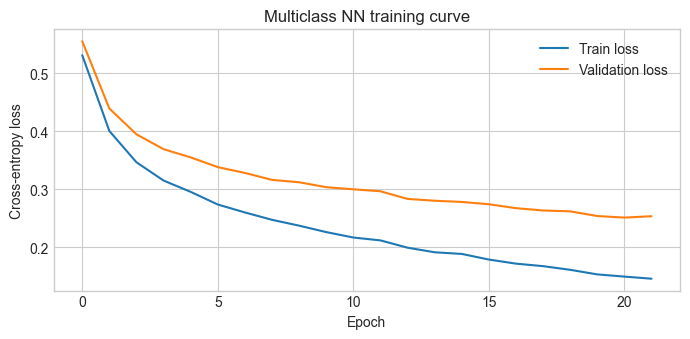

**Metric comparison: binary vs multiclass neural net**

,Task,Accuracy,Precision,Recall,F1
0,Binary NN (1 vs not 1),0.995000,0.976540,0.979412,0.977974
1,Multiclass NN (0-9),0.935333,0.935032,0.934684,0.934590


In [27]:
# Multiclass train/validation split
X_multi_train, X_multi_val, y_multi_train, y_multi_val = train_test_split(
    X_train_nn,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

print('Training multiclass neural network from scratch (0-9)...')
multi_params, multi_history = train_multiclass_nn(
    X_multi_train,
    y_multi_train,
    X_multi_val,
    y_multi_val,
    hidden_dim=96,
    epochs=22,
    lr=0.09,
    batch_size=128,
)

plt.figure(figsize=(7, 3.5))
plt.plot(multi_history['train_loss'], label='Train loss')
plt.plot(multi_history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy loss')
plt.title('Multiclass NN training curve')
plt.legend()
plt.tight_layout()
plt.show()

multi_probs_test, _ = multi_forward(X_test_nn, multi_params)
multi_pred_test = np.argmax(multi_probs_test, axis=1)

multi_acc = accuracy_score(y_test, multi_pred_test)
multi_prec_macro = precision_score(y_test, multi_pred_test, average='macro', zero_division=0)
multi_rec_macro = recall_score(y_test, multi_pred_test, average='macro', zero_division=0)
multi_f1_macro = f1_score(y_test, multi_pred_test, average='macro', zero_division=0)

binary_default = binary_metrics_from_threshold(y_test_bin, bin_test_prob, threshold=0.5)

comparison_df = pd.DataFrame([
    {
        'Task': 'Binary NN (1 vs not 1)',
        'Accuracy': binary_default['accuracy'],
        'Precision': binary_default['precision'],
        'Recall': binary_default['recall'],
        'F1': binary_default['f1'],
    },
    {
        'Task': 'Multiclass NN (0-9)',
        'Accuracy': multi_acc,
        'Precision': multi_prec_macro,
        'Recall': multi_rec_macro,
        'F1': multi_f1_macro,
    },
])

display(Markdown('**Metric comparison: binary vs multiclass neural net**'))
display(comparison_df)

multi_report_dict = classification_report(y_test, multi_pred_test, output_dict=True, zero_division=0)
multi_cm = confusion_matrix(y_test, multi_pred_test)

In [28]:
def multiclass_dashboard(focus_digit=1, sample_index=0, normalize=False):
    if normalize:
        cm_display = multi_cm / np.maximum(multi_cm.sum(axis=1, keepdims=True), 1)
    else:
        cm_display = multi_cm

    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

    im = axes[0].imshow(cm_display, cmap='Blues')
    axes[0].set_title('Multiclass confusion matrix' + (' (row-normalized)' if normalize else ''))
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_xticks(range(10))
    axes[0].set_yticks(range(10))

    focus_key = str(focus_digit)
    row = multi_report_dict.get(focus_key, {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0})
    metric_vals = [row['precision'], row['recall'], row['f1-score']]
    axes[1].bar(['Precision', 'Recall', 'F1'], metric_vals, color=['#2563eb', '#f59e0b', '#16a34a'])
    axes[1].set_ylim(0, 1.0)
    axes[1].set_title(f'Per-class metrics for digit {focus_digit}')

    sample_index = int(np.clip(sample_index, 0, len(X_test_raw) - 1))
    prob = multi_probs_test[sample_index]
    pred = int(np.argmax(prob))
    true = int(y_test[sample_index])

    axes[2].bar(np.arange(10), prob, color='#7c3aed')
    axes[2].set_xticks(range(10))
    axes[2].set_ylim(0, 1)
    axes[2].set_title(f'Sample idx={sample_index}: true={true}, pred={pred}')
    axes[2].set_xlabel('Digit class')
    axes[2].set_ylabel('Probability')

    plt.tight_layout()
    plt.show()

    img = X_test_raw[sample_index].reshape(IMAGE_SIDE, IMAGE_SIDE)
    plt.figure(figsize=(2.6, 2.6))
    plt.imshow(img, cmap='gray')
    plt.title(f'Test sample idx {sample_index}')
    plt.axis('off')
    plt.show()

    details = pd.DataFrame([
        {
            'Digit': focus_digit,
            'Precision': row['precision'],
            'Recall': row['recall'],
            'F1': row['f1-score'],
            'Support': int(row['support']),
        }
    ])
    display(details)


widgets.interact(
    multiclass_dashboard,
    focus_digit=widgets.IntSlider(min=0, max=9, step=1, value=1, description='Focus digit'),
    sample_index=widgets.IntSlider(min=0, max=len(X_test_raw) - 1, step=1, value=0, description='Sample idx'),
    normalize=widgets.Checkbox(value=False, description='Normalize CM'),
)

interactive(children=(IntSlider(value=1, description='Focus digit', max=9), IntSlider(value=0, description='Sa…

<function __main__.multiclass_dashboard(focus_digit=1, sample_index=0, normalize=False)>

## Section 6: What changed when we moved from binary to multiclass?
Binary (1 vs not 1):
- Easier boundary
- Threshold tuning gives direct control over TP/FP trade-offs

Multiclass (0-9):
- Harder task (10 classes)
- More complex confusion patterns (e.g., 3 vs 5, 4 vs 9)
- Per-class metrics become essential

In [29]:
top_confusions = []
cm_no_diag = multi_cm.copy().astype(int)
np.fill_diagonal(cm_no_diag, 0)

for true_digit in range(10):
    pred_digit = int(np.argmax(cm_no_diag[true_digit]))
    count = int(cm_no_diag[true_digit, pred_digit])
    top_confusions.append({'True digit': true_digit, 'Most confused as': pred_digit, 'Count': count})

confusion_df = pd.DataFrame(top_confusions).sort_values('Count', ascending=False)
display(Markdown('**Top confusion pairs (multiclass NN)**'))
display(confusion_df)

pipeline_checklist = pd.DataFrame([
    {'Pipeline stage': 'Data loading', 'Status': 'Done'},
    {'Pipeline stage': 'EDA and labels', 'Status': 'Done'},
    {'Pipeline stage': 'Normalization', 'Status': 'Done'},
    {'Pipeline stage': 'Traditional ML prediction', 'Status': 'Done'},
    {'Pipeline stage': 'Traditional ML grouping', 'Status': 'Done'},
    {'Pipeline stage': 'Binary NN from scratch', 'Status': 'Done'},
    {'Pipeline stage': 'Threshold and confusion metrics', 'Status': 'Done'},
    {'Pipeline stage': 'Multiclass NN from scratch', 'Status': 'Done'},
])
display(Markdown('**Pipeline checklist**'))
display(pipeline_checklist)

**Top confusion pairs (multiclass NN)**

,True digit,Most confused as,Count
9,9,4,11
4,4,9,9
2,2,3,8
8,8,5,8
3,3,5,7
5,5,3,6
6,6,5,6
7,7,9,6
0,0,7,2
1,1,8,2


**Pipeline checklist**

,Pipeline stage,Status
0,Data loading,Done
1,EDA and labels,Done
2,Normalization,Done
3,Traditional ML prediction,Done
4,Traditional ML grouping,Done
5,Binary NN from scratch,Done
6,Threshold and confusion metrics,Done
7,Multiclass NN from scratch,Done


## Try this next
1. Change hidden layer sizes and compare training curves.
2. Train on fewer samples and observe which digits degrade first.
3. Move binary threshold from 0.1 to 0.9 and write how sensitivity/specificity change.
4. Compare logistic regression errors vs neural network errors for the same test samples.